# TomoPy test 01
Reconstruction test on small TOMCAT dataset
06-11-2020

see also:
https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html

#### Activate TomoPy kernel in Jupyter:
`conda env list`

`source activate tomopy`

`python -m ipykernel install --user --name tomopy --display-name "Python3 (TomoPy)"`

`jupyter notebook &`

In [20]:
import os
import dxchange
import tomopy
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt

In [28]:
matplotlib.rcParams['figure.dpi'] = 150

In [22]:
import logging
logging.basicConfig(level=logging.INFO)

In [23]:
h5file = "/home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5"
path_recon = "/home/gianthk/Data/StefanFly_test/test_00_/recon/"

In [24]:
Fiij_exe = '/home/gianthk/Applications/Fiji.app/ImageJ-linux64'
Fiji_exe_stack = Fiij_exe + ' -macro /home/gianthk/Applications/Fiji.app/macros/FolderOpener_virtual.ijm '

#### Read TOMCAT data
- The .read_aps_32id() method of DXchange can read TOMCAT .h5 data
- If run without arguments (proj..), the import seem to be virtual (mem map)? I don't see this data in the RAM and I can reconstruct the whole volume on my laptop!

In [25]:
# read the full proj
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

# read one projection every 10
# projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, proj=[1, 1000, 10])

INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5
INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5
INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5
INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5


In [26]:
projs.shape[:]
# projs = projs[:,300:500,:]

(1001, 962, 960)

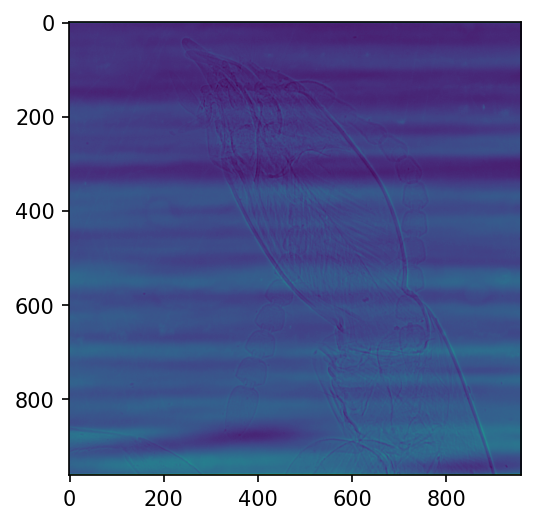

In [29]:
plt.imshow(projs[200, :, :])
plt.show()

If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case, theta is set as equally spaced between 0-180 degrees.

In [30]:
if theta is None:
    theta = tomopy.angles(projs.shape[0])

#### Flat field correction

In [31]:
projs_norm = tomopy.normalize(projs, flats, darks)

#### Find the Center Of Rotation (auto)

In [32]:
COR = tomopy.find_center(projs_norm, theta, init=projs.shape[2]/2, ind=500, tol=0.5)

Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Trying rotation center: [480.]
INFO:tomopy.recon.rotation:Function value = 1.532220
INFO:tomopy.recon.rotation:Trying rotation center: [504.]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.542185
INFO:tomopy.recon.rotation:Trying rotation center: [456.]
INFO:tomopy.recon.rotation:Function value = 1.536431
INFO:tomopy.recon.rotation:Trying rotation center: [468.]
INFO:tomopy.recon.rotation:Function value = 1.515886
INFO:tomopy.recon.rotation:Trying rotation center: [456.]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.536431
INFO:tomopy.recon.rotation:Trying rotation center: [474.]
INFO:tomopy.recon.rotation:Function value = 1.516384
INFO:tomopy.recon.rotation:Trying rotation center: [462.]
INFO:tomopy.recon.rotation:Function value = 1.523889
INFO:tomopy.recon.rotation:Trying rotation center: [471.]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.513328
INFO:tomopy.recon.rotation:Trying rotation center: [474.]
INFO:tomopy.recon.rotation:Function value = 1.516384
INFO:tomopy.recon.rotation:Trying rotation center: [469.5]
INFO:tomopy.recon.rotation:Function value = 1.514182
INFO:tomopy.recon.rotation:Trying rotation center: [472.5]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.514257
INFO:tomopy.recon.rotation:Trying rotation center: [470.25]
INFO:tomopy.recon.rotation:Function value = 1.513888
INFO:tomopy.recon.rotation:Trying rotation center: [471.75]
INFO:tomopy.recon.rotation:Function value = 1.514416
INFO:tomopy.recon.rotation:Trying rotation center: [470.625]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.513065


#### Reconstruction with Gridrec

The COR from the step above seem to have an offset...

In [30]:
recon = tomopy.recon(projs_norm, theta, center=COR, algorithm='gridrec', sinogram_order=False)

Reconstructing 8 slice groups with 8 master threads...


Apply circular mask

In [32]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

Visualize results

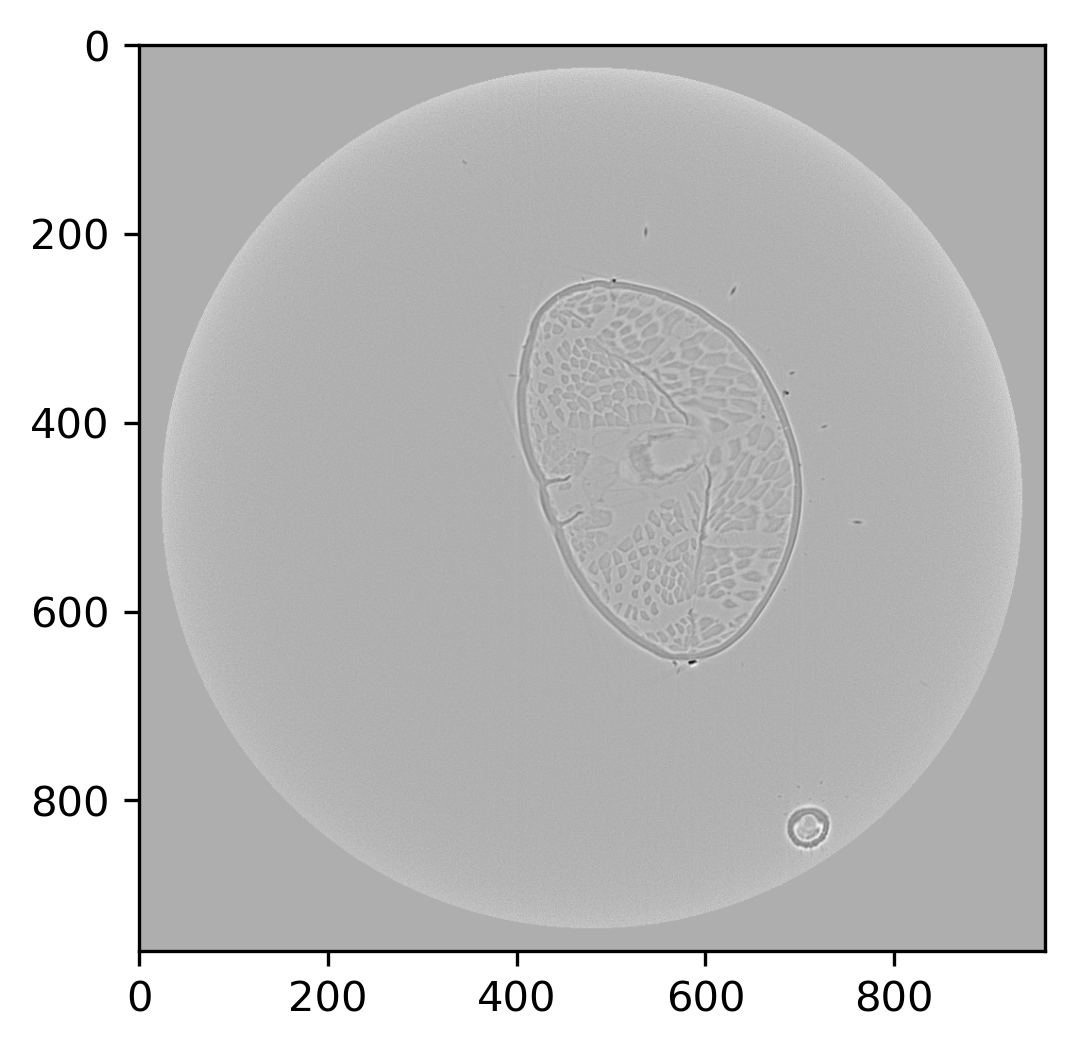

In [36]:
plt.imshow(recon[500, :, :], cmap='gray')
plt.show()

#### Write output Tiff stack

In [6]:
fileout = path_recon+'data.tiff'
dxchange.writer.write_tiff_stack(recon, fname=fileout, dtype=None, axis=0, digit=5, start=0, overwrite=False)

#### Open virtual stack in ImageJ

In [19]:
os.system(Fiji_exe_stack + '/home/gianthk/Data/StefanFly_test/test_00_/rec_8bit_0/test_00_001.rec.8bit.tif &')

0

#### Save images reconstructed with a range of rotation centers.

In [35]:
tomopy.write_center(projs_norm, theta, dpath=path_recon+'tmp/COR', cen_range=[COR-10, COR+10, 1], ind=500, mask=True, ratio=1.0, algorithm='gridrec', filter_name='parzen')

Reconstructing 20 slice groups with 8 master threads...


View them in Fiji

In [64]:
os.system(Fiji_exe_stack + path_recon+'tmp/COR/'+'{:04.2f}'.format(COR[0])+'.tiff &')

0

Optimize the reconstruction around given COR

In [67]:
tomopy.write_center(projs_norm, theta, dpath=path_recon+'tmp/COR', cen_range=[482, 490, 0.5], ind=500, mask=True, ratio=1.0, algorithm='gridrec', filter_name='parzen')

Reconstructing 16 slice groups with 8 master threads...


View them in Fiji

In [69]:
os.system(Fiji_exe_stack + path_recon+'tmp/COR/482.00.tiff &')

0